### Priority Queue kNN

This notebook implements vanilla kNN to classify handwritten digits available [here](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

As seen in the previous notebook, given that there are m training samples and the Eucledian distance calculation between two points in feature space of n dimensions is of constant time complexity, the vanilla kNN has a worst time complexity of **O(k * m * 1)** where k is the chosen value for kNN. As seen in the graph of that notebook, with the increase in the size of k, there is a rapid increase in the total time taken for the algorithm to run at test time. This can be attributed to the fact that for each test sample i, the distance between the test sample i and each training example has to be calculated to determine which k training samples are the closest to the test sample i.<br><br>Instead, if we can maintain a priority queue (also called a min heap when implemented using a min heap tree data structure) such that a minheap structure is maintained throughout the whole process, the closest k training samples can be identified after a single sweep through the training samples instead of m sweeps. Hence, the worst time complexity for this implementation of kNN becomes O(m * (log k + log k) ) = **O(m * log k)**. The two log k operations are a) heapify when the minheap entry count reaches k for the first time, and b) to heappush each new training sample into the minheap after the total element count in the minheap reaches k.

#### Import Libraries

In [1]:
import os
import sys
import time

import heapq
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from statistics import mode
import matplotlib.pyplot as plt

root_dir_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(root_dir_path)
import utils

pd.set_option("display.max_colwidth", None)

In [2]:
# load the dataset
digits_data = load_digits()
X = digits_data.data
y = digits_data.target
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train[0:2, :]

array([[ 0.,  0.,  5., 13., 13.,  8.,  0.,  0.,  0.,  0., 16., 11., 13.,
        16.,  6.,  0.,  0.,  1., 16.,  5.,  2., 14.,  9.,  0.,  0.,  0.,
         9., 16., 16., 15.,  0.,  0.,  0.,  0., 10., 16., 14., 14.,  0.,
         0.,  0.,  5., 15.,  4.,  0., 16.,  6.,  0.,  0.,  6., 14.,  7.,
         6., 16.,  4.,  0.,  0.,  0.,  7., 15., 16., 10.,  0.,  0.],
       [ 0.,  0.,  3., 14., 16., 14.,  0.,  0.,  0.,  0., 13., 13., 13.,
        16.,  2.,  0.,  0.,  0.,  1.,  0.,  9., 15.,  0.,  0.,  0.,  0.,
         9., 12., 15., 16., 10.,  0.,  0.,  4., 16., 16., 16., 11.,  3.,
         0.,  0.,  0.,  4.,  9., 14.,  2.,  0.,  0.,  0.,  0.,  2., 15.,
         9.,  0.,  0.,  0.,  0.,  0.,  4., 13.,  1.,  0.,  0.,  0.]])

In [3]:
# unique values and their counts
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} time(s).")

0 occurs 125 time(s).
1 occurs 132 time(s).
2 occurs 130 time(s).
3 occurs 129 time(s).
4 occurs 121 time(s).
5 occurs 116 time(s).
6 occurs 128 time(s).
7 occurs 124 time(s).
8 occurs 131 time(s).
9 occurs 121 time(s).


Scale the training and test data.

In [4]:
normalized_training_features = utils.minmax_normalize_2d_array(X_train)
normalized_test_features = utils.minmax_normalize_2d_array(X_test)
X_train = None
X_test = None
normalized_training_features[0:2, :]

array([[0.        , 0.        , 0.3125    , 0.8125    , 0.8125    ,
        0.5       , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.6875    , 0.8125    , 1.        , 0.375     ,
        0.        , 0.        , 0.0625    , 1.        , 0.3125    ,
        0.125     , 0.875     , 0.5625    , 0.        , 0.        ,
        0.        , 0.5625    , 1.        , 1.        , 0.9375    ,
        0.        , 0.        , 0.        , 0.        , 0.625     ,
        1.        , 0.875     , 0.875     , 0.        , 0.        ,
        0.        , 0.3125    , 0.9375    , 0.25      , 0.        ,
        1.        , 0.375     , 0.        , 0.        , 0.375     ,
        0.875     , 0.4375    , 0.375     , 1.        , 0.25      ,
        0.        , 0.        , 0.        , 0.4375    , 0.9375    ,
        1.        , 0.625     , 0.        , 0.        ],
       [0.        , 0.        , 0.1875    , 0.875     , 1.        ,
        0.875     , 0.        , 0.        , 0.        , 0. 

In [5]:
class kNN_with_Priority_Queue:
    def __init__(self, training_features, training_labels, k):
        """
        Stores the training features and labels.
        """
        self.X_train = training_features
        self.y_train = training_labels
        self.k = k

    def fit(self):
        """
        No training step for a lazy learner.
        """
        pass

    def predict(self, test_sample):
        min_heap = []
        # TC: O(m) where m is the # of tr. samples
        for idx, sample in enumerate(self.X_train):
            curr_euclidean_distance = np.linalg.norm(test_sample - sample)
            if len(min_heap) < self.k:
                min_heap.append((curr_euclidean_distance, self.y_train[idx]))
            elif len(min_heap) == self.k:
                # TC: O(log k)
                heapq.heapify(min_heap)
                # TC: O(log k)
                heapq.heappush(min_heap, (curr_euclidean_distance, self.y_train[idx]))
            else:
                # TC: O(log k)
                heapq.heappush(min_heap, (curr_euclidean_distance, self.y_train[idx]))

        # get the mode of the top k closest training samples as the plurality vote
        nearest_predictions = []
        for idx in range(0, self.k):
            nearest_predictions.append(heapq.heappop(min_heap)[1])
        return mode(nearest_predictions)

#### Inference

In [6]:
# predict test samples
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
accuracies = []
time_taken = []
for k in k_values:
    start_time = time.time()
    kNN = kNN_with_Priority_Queue(normalized_training_features, y_train, k)
    preds = []
    for test_sample_idx in range(0, len(y_test)):
        prediction = kNN.predict(normalized_test_features[test_sample_idx, :])
        preds.append(prediction)
    accuracy = utils.calculate_accuracy(y_test, preds)

    accuracies.append(accuracy)
    end_time = time.time()
    time_taken.append(round(end_time - start_time, 2))
    print(
        "For k == ",
        k,
        ", accuracy: ",
        accuracy,
        ", Time taken: ",
        round(end_time - start_time, 3),
    )

For k ==  1 , accuracy:  98.51851851851852 , Time taken:  2.464
For k ==  5 , accuracy:  99.07407407407408 , Time taken:  2.41
For k ==  10 , accuracy:  97.96296296296296 , Time taken:  2.389
For k ==  15 , accuracy:  97.77777777777777 , Time taken:  2.427
For k ==  20 , accuracy:  97.4074074074074 , Time taken:  2.372
For k ==  25 , accuracy:  96.66666666666667 , Time taken:  2.358
For k ==  30 , accuracy:  96.66666666666667 , Time taken:  2.392
For k ==  35 , accuracy:  95.74074074074073 , Time taken:  2.354
For k ==  40 , accuracy:  95.0 , Time taken:  2.388
For k ==  45 , accuracy:  94.44444444444444 , Time taken:  2.374
For k ==  50 , accuracy:  93.7037037037037 , Time taken:  2.391


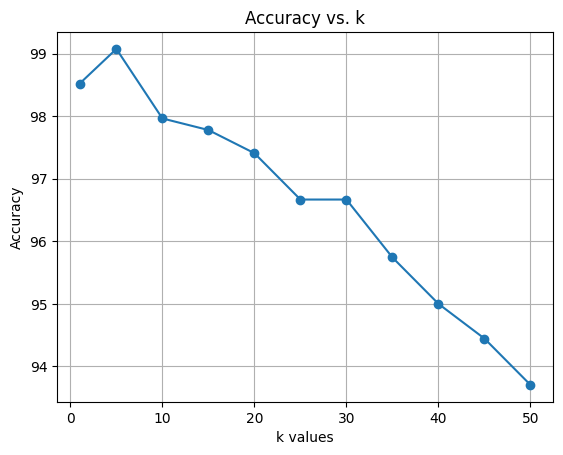

In [7]:
# Plot the accuracies
plt.plot(k_values, accuracies, marker="o")
plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. k")
plt.grid(True)
plt.show()

#### Time Taken

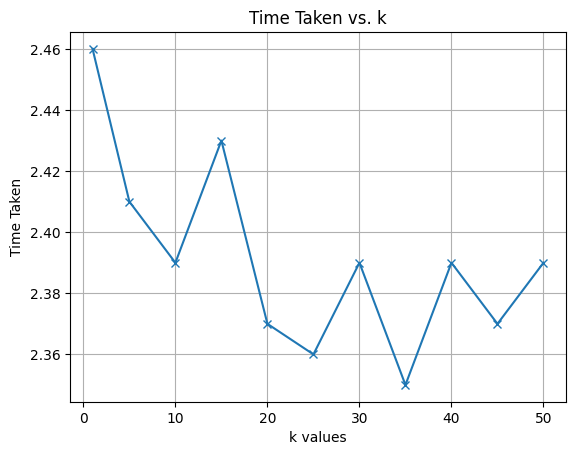

In [8]:
# Plot the accuracies
plt.plot(k_values, time_taken, marker="x")
plt.xlabel("k values")
plt.ylabel("Time Taken")
plt.title("Time Taken vs. k")
plt.grid(True)
plt.show()

#### Comparison of Time Taken - Vanilla kNN vs Priority Queue kNN

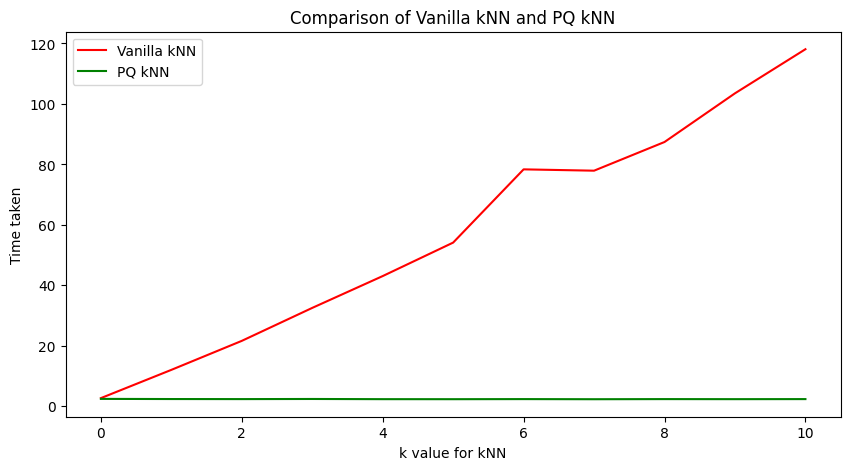

In [9]:
# Given two lists
time_taken_vanilla_kNN = [
    2.715,
    12.057,
    21.649,
    32.551,
    43.075,
    54.149,
    78.367,
    77.928,
    87.413,
    103.512,
    118.096,
]
time_taken_PQ_kNN = time_taken
x_values = list(range(len(k_values)))
vanilla_kNN_color = "red"
PQ_kNN_color = "green"
plt.figure(figsize=(10, 5))

# Plot the two graphs
plt.plot(x_values, time_taken_vanilla_kNN, label="Vanilla kNN", color=vanilla_kNN_color)
plt.plot(x_values, time_taken_PQ_kNN, label="PQ kNN", color=PQ_kNN_color)

# Set labels for the axes and a title for the plot
plt.xlabel("k value for kNN")
plt.ylabel("Time taken")
plt.title("Comparison of Vanilla kNN and PQ kNN")

# Add a legend to differentiate between the two graphs
plt.legend()
# Show the plot
plt.show()

As seen above, the time taken by the priority queue version of kNN is significantly better than the vanilla kNN for the same k values used on the same data.